# Variant 29
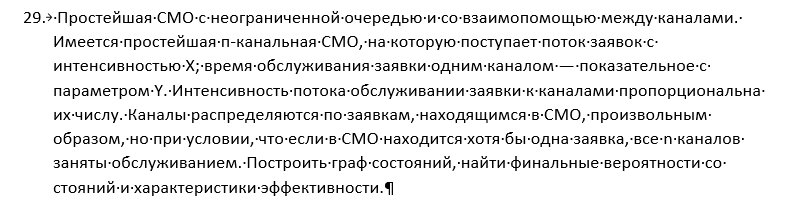


Многоканальная система с неограниченной очередью при равномерной взаимопомощи каналов
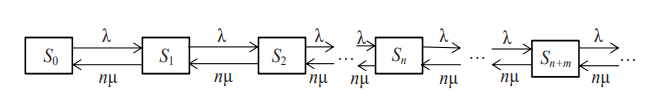

$$ X=\frac{\lambda}{\mu*n} $$

$$ n \leq n_{xy} $$
$$ T_{обслуж} = \frac{1}{\mu} = \frac{1}{Y} $$ 
Для того, чтобы длина очереди не увеличивалась до бесконечности
и система оставалась работоспособной, чтобы существовали предельные
вероятности состояний системы, необходимо выполнение условия: X < 1.
Будем предполагать его выполненным. Будем также считать, что условие (2) верно,
т. е. каналы не мешают друг другу при совместном обслуживании одной заявки,
интенсивность такого обслуживания пропорциональна числу обслуживающих каналов: μ(k) = kμ.

# Предельные вероятности состояний
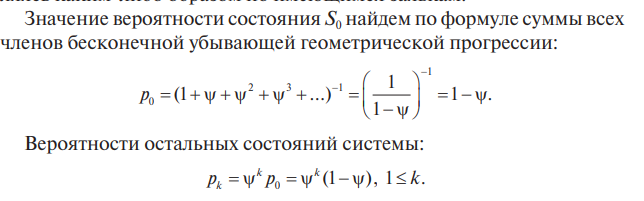
$$p_{0}=1-X   $$
$$p_{k}=X^k*(1-X), k \geq 1$$

# Вероятность наличия очереди
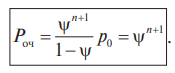
$$P_{оч} = X^{n+1} $$

# Показатели эффективности СМО:
A - абсолютная пропускная способность (среднее число заявок, обслуживаемых в СМО в единицу времени
<br>
Q - относительная пропускная способность (вероятность обслуживания поступившей в СМО заявки)
<br>
Pотк - вероятность отказа заявке в СМО
<br>
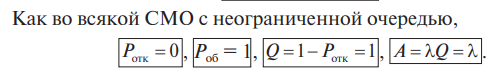
$$\lambda = X*Y*n = A$$
$$\rho = \frac{\lambda}{\mu} = \frac{X*Y*n}{Y}=X*n $$ 

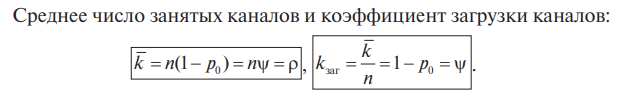
$$\hat{k} = \rho = X*n $$
$$k_{загр} = X$$

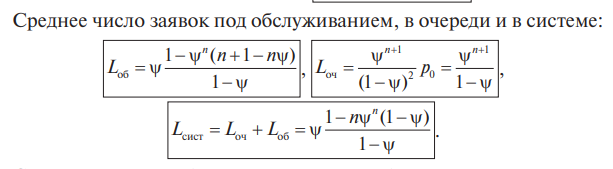

$$ L_{осблуж} = X*\frac{1-X^n*(n+1-n*X)}{1-X}   $$
$$ L_{очер} = \frac{X^{n+1}}{1-X}  $$
$$ L_{сист} = L_{осблуж} + L_{очер} = X * \frac{1-n*X^n*(1-X)}{1-X}  $$

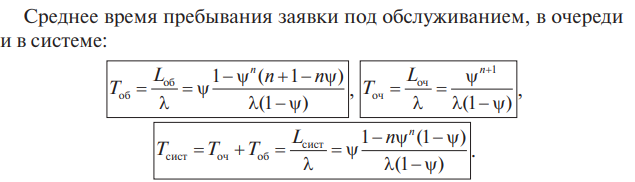

$$ T_{обслуж} = \frac{L_{осблуж}}{\lambda} = X*\frac{1-X^n*(n+1-n*X)}{(X*Y*n)*(1-X)}  $$
$$ T_{очер} = \frac{L_{очер}}{\lambda} = \frac{X^{n+1}}{(X*Y*n)*(1-X)}  $$
$$ T_{сист} = T_{обслуж} + T_{очер} = \frac{L_{сист}}{\lambda} = X*\frac{1-n*X^n*(1-X)}{(X*Y*n)*(1-X)}  $$

# Моделирование СМО (Системы массового обслуживания)

In [3]:
import random
import simpy
import time 
from IPython.display import clear_output

RANDOM_SEED = 42
AMOUNT_OF_SERVERS = 3 # n
SIMULATION_TIME = 100
SERVICE_TIME = 3 # T(обслуж)
X = 1/3
Y=1/SERVICE_TIME
n=AMOUNT_OF_SERVERS

values = {
    'appeared': [],
    'queue': [],
    'served': [],
    'left': []
}
time_intervals = {
    'queue': {},
    'served': {}
}


def show_status(is_showing=True):
    if not is_showing:
        return

    appeared=values['appeared']
    queue=values['queue']
    served=values['served']
    left=values['left']
    
    clear_output(wait=True)
    time.sleep(0.5)
    
    print('-'*50)
    print(f'Appeared: { appeared }')
    print(f'Queue: { queue }')
    print(f'Served: { served }')
    print(f'Left: { left }')
    
    print('-'*50)
    values['left'].clear()


class Server:
    def __init__(self, env, service_time):
        self.server = simpy.Resource(env, capacity=AMOUNT_OF_SERVERS)
        self.service_time = service_time

    def service(self):
        yield env.timeout(random.expovariate(1 / self.service_time))


def customer(env, name, queue):       
    values['appeared'].append(name)
    show_status()
    
    with queue.server.request() as request:
        values['queue'].append(name)
        values['appeared'].remove(name)
        show_status()
        
        time_intervals['queue'][name] = (env.now, )

        yield request
        
        values['served'].append(name)
        values['queue'].remove(name)
        show_status()
        
        time_intervals['served'][name] = (env.now, )
        time_intervals['queue'][name] += (env.now,)

        yield env.process(queue.service())
        
        values['left'].append(name)
        values['served'].remove(name)
        show_status()
        
        time_intervals['served'][name] += (env.now,)


def customer_arrivals(env, queue):
    i=0
    while True:
        i += 1
        yield env.timeout(random.expovariate(X*n*Y))
        env.process(customer(env, f'{i}', queue))


def get_characteristics(values):
    intervals_list = []
    
    for item in values:   
        try:
            intervals_list.append(item[1] - item[0])
        except:
            pass
            
    return intervals_list


def get_theary_values():
    up = 1-(X**n)*(n+1-n*X)
    down = (X*Y*n)*(1-X)

    return X*up/down, (X**(n+1))/down
    
random.seed(RANDOM_SEED)
env = simpy.Environment()
queue = Server(env, SERVICE_TIME)
env.process(customer_arrivals(env, queue))
env.run(until=SIMULATION_TIME)

queue_mean = get_characteristics(time_intervals['queue'].values())
searved_mean = get_characteristics(time_intervals['served'].values())
 
# served, queue = get_theary_values()
# print(f'Mean queue time: {queue_mean}--{queue}')
# print(f'Mean searved time: {searved_mean}--{served}')


--------------------------------------------------
Appeared: []
Queue: []
Served: []
Left: ['38']
--------------------------------------------------


In [219]:
import numpy as np
from scipy import stats

def check(real, estims, alpha=0.05):
    main_estim = np.mean(estims)
    se_estim = np.sqrt(np.var(estims))
    
    w_abs = abs((main_estim - real) / se_estim)
    p_value = 2 * stats.norm.cdf(-w_abs)
    
    low_p = real - se_estim * stats.norm.ppf(1 - alpha / 2)
    upper_p = real + se_estim * stats.norm.ppf(1 - alpha / 2)
    
    print("теоретические данные: ", real)
    print("точечная оценка: ", main_estim)
    print(f"{1 - alpha}% интервальная оценка: [{low_p}, {upper_p}]")
    print("p_value: ", p_value)

check(queue, np.array(queue_mean))
check(served, np.array(searved_mean))

теоретические данные:  0.05555555555555554
точечная оценка:  0.09137069192188285
0.95% интервальная оценка: [-0.643410914405884, 0.7545220255169952]
p_value:  0.9200038908480884
теоретические данные:  1.3333333333333333
точечная оценка:  3.0412182249227957
0.95% интервальная оценка: [-4.216268015520949, 6.882934682187615]
p_value:  0.5463908286584244
